# Simple epicenter problem

This notebook illustrates a simple method for estimating the horizontal coordinates of an epicenter.

## Geophysical problem

An earthquake generates seismic waves that propagate in the subsusface and are detected by three of seismic stations, A, B and C (green triangles), located on the Earth's surface.

<img src='epicenter_figs\fig1.png', width=700>

Let's consider that, at each station, there is a measure of the difference between the first arrivals of the P and S waves.

<img src='epicenter_figs\fig2.png', width=700>

## Parameterization and forward problem

By considering that (i) the ray paths can be approximated by straight lines, (ii) the depth of the hypocenter can be negleted and also that (iii) the crust is homogeneous and isotropic, we can define a time difference $\Delta t_{i}$, $i = A, B, C$, as a function of the:

* seismic velocities $v_{P}$ and $v_{S}$;

* station coordinates $x_{i}$ and $y_{i}$, $i = A, B, C$;

* epicenter coordinates $x_{0}$ and $y_{0}$.

Here, we consider a Cartesian coordinate system in which $x$ points to North, $y$ points to East and $z$ points to the subsurface.

In this case, the time differences can be written as follows:

$$
\Delta t_{i} (\mathbf{p}) = \alpha \,
\left[ \left( x_{i} - x_{0} \right)^{2} + \left( y_{i} - y_{0} \right)^{2} \right]^{-\frac{1}{2}} \: ,
$$

where

$$
\mathbf{p} = 
\left[ \begin{array}{c}
x_{0} \\
y_{0}
\end{array} \right]
$$

contains the parameters to be estimated (parameter vector) and

$$
\alpha = \frac{1}{v_{S}} - \frac{1}{v_{P}} \: .
$$

From these equations, we obtain a predicted data vector given by:

$$
\mathbf{\Delta t}(\mathbf{p}) =
\alpha \, \left[ \begin{array}{c}
\Delta t_{A} (\mathbf{p}) \\
\Delta t_{B} (\mathbf{p}) \\
\Delta t_{C} (\mathbf{p})
\end{array} \right] \: .
$$

## Synthetic data

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

#### Limits of the simulated study area

In [2]:
# limits of the study area in km
xmin = 0.
xmax = 100.
ymin = -50.
ymax = 50.

#### Seismic velocities

In [3]:
# seismic velocities in km/s
vp = 6.5
vs = 6.5/1.6

#### Coordinates of the epicenter

In [4]:
# coordinates of the simulated epicenter in km
p_true = np.array([[50.],
                   [0.]])

#### Coordinates of the seismic stations

In [5]:
# coordinates of the seismic stations in km
x = np.array([[10.],
              [80.],
              [7.]])

y = np.array([[-40.],
              [0.],
              [35.]])

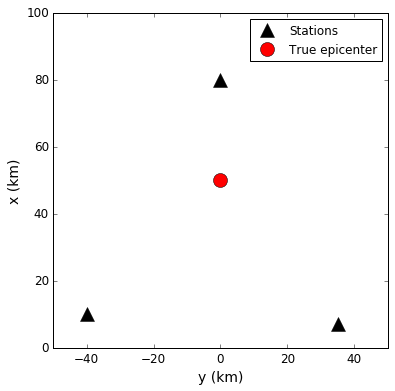

In [6]:
plt.figure(figsize=(8,6))
plt.axis('scaled')
plt.plot(y,x,'k^', markersize=14, label='Stations')
plt.plot([p_true[1]], [p_true[0]], 'ro', markersize=14, label='True epicenter')
plt.xlabel('y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=14)
plt.legend(loc='best', numpoints=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(ymin,ymax)
plt.ylim(xmin,xmax)
plt.show()

#### Synthetic data vector

Let's simulate a time difference data set and store them into a vector `d`. This vector represents an observed data vector containing the measured time differences at each station.

In [7]:
def data(vp,vs,x,y,p):
    '''
    input
    vp: float - seismic velocity vp
    vs: float - seismic velocity vs
    x: numpy array - coordinates x of the sations
    y: numpy array - coordinates y of the sations
    p: numpy array - true parameter vector
    
    output
    dt: numpy array - vector containing the simulated 
    time differences
    '''
    
    assert (vp > vs), 'vp must be greater than vs'
    
    assert (x.size == y.size), 'x and y must have the same number of elements'
    
    assert (vp != 0.) and (vs != 0.), 'vp and vs must be different from zero'
    
    alfa = 1./vs - 1./vp
    
    return alfa*np.sqrt((x - p[0])**2 + (y - p[1])**2)

In [8]:
d = data(vp, vs, x, y, p_true)

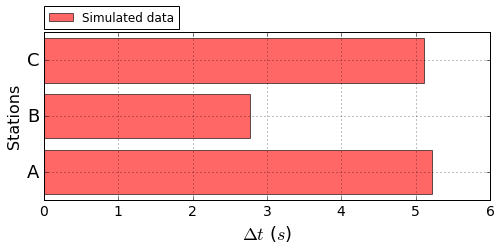

In [9]:
plt.figure(figsize=(8,3))
stations_label = ['A', 'B', 'C']
stations = [1,2,3]

plt.barh(stations, d, align='center', 
         color='r', alpha=0.6, label='Simulated data')
plt.yticks(stations, stations_label, fontsize=18)
plt.xticks(fontsize=14)
plt.xlabel('$\Delta t$ ($s$)', fontsize=18)
plt.ylabel('Stations', fontsize=16)
plt.grid()
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), 
           loc=3, ncol=2, borderaxespad=0.)
plt.show()

#### Goal function

The coordinates of the simulated epicenter can be estimated by estimating the parameter vector `p` minimizing the following goal function:

$$
\Phi(\mathbf{p}) = \left[ \mathbf{d} - \mathbf{\Delta t}(\mathbf{p}) \right]^{\, \top}\left[ \mathbf{d} - \mathbf{\Delta t}(\mathbf{p}) \right]
$$

This is a function depending on two parameters, which represent the Cartesian coordinates of the epicenter. It means that, given a point $(x_{0},y_{0})$, and consequently a vector $\mathbf{p}$, we can calculate the function $\Phi(\mathbf{p})$. Then, if we define a grid of points $(x_{0},y_{0})$, each one representing a possible epicenter, we can calculate the goal function $\Phi(\mathbf{p})$ on a grid.

The grid of points representing possible epicenter can be defined as follows:

In [10]:
# number of points along the x and y axes
Nx = 200
Ny = 200

In [11]:
# grid of Nx by Ny points

x0_grid = np.linspace(xmin, xmax, Nx)
y0_grid = np.linspace(ymin, ymax, Ny)

print x0_grid.shape, ',', y0_grid.shape

x0_grid, y0_grid = np.meshgrid(x0_grid,y0_grid)

print x0_grid.shape, ',', y0_grid.shape

(200L,) , (200L,)
(200L, 200L) , (200L, 200L)


In [12]:
def goal_function(d,vp,vs,x,y,x0,y0):
    '''
    Calculates the goal function at a set of points (x0, y0).
    
    input
    
    vp: float - seismic velocity vp
    vs: float - seismic velocity vs
    x: numpy array - coordinates x of the stations
    y: numpy array - coordinates y of the stations
    x0: numpy array - coordinates x0 of the points at which the
        goal function is calculated
    y0: numpy array - coordinates y0 of the points at which the
        goal function is calculated

    output
    phi: numpy array - vector containing the calculated goal function     
    '''
    
    assert (vp > vs), 'vp must be greater than vs'
    
    assert (x.size == y.size), 'x and y must have the same number of elements'
    
    assert (vp != 0.) and (vs != 0.), 'vp and vs must be different from zero'
    
    alfa = 1./vs - 1./vp
   
    phi = np.zeros_like(x0)
    for xs, ys, dt in zip(x, y, d):
        phi += (dt - alfa*np.sqrt((xs - x0)**2 + (ys - y0)**2))**2
    return phi

In [13]:
phi_grid = goal_function(d,vp,vs,x,y,x0_grid,y0_grid)

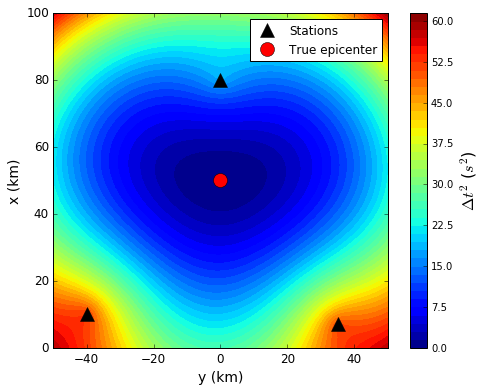

In [14]:
plt.figure(figsize=(8,6))
plt.axis('scaled')
plt.contourf(y0_grid,x0_grid,phi_grid,40)
cbar = plt.colorbar()
cbar.set_label('$\Delta t^{2}$ ($s^{2}$)', fontsize=16)
plt.plot(y,x,'k^', markersize=14, label='Stations')
plt.plot([p_true[1]], [p_true[0]], 'ro', markersize=14, label='True epicenter')
plt.xlabel('y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=14)
plt.legend(loc='best', numpoints=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(ymin,ymax)
plt.ylim(xmin,xmax)
plt.show()

Notice that the minimum of the goal function is located at the point representing the true epicenter (red circle).

### Exercise 22

1) Create a function for calculating the Jacobian matrix. This function must receive `vp`, `vs` (the seismic velocities), `x`, `y` (the coordinates of the stations) and `p` (a parameter vector) and return the Jacobian matrix `G`. This function must look like:

    def jacobian(vp,vs,x,y,p):
        '''
        Brief description of this function
        text text text ...

        input
        text text text ...

        output
        text text text ...
        '''

        assert (vp > vs), 'vp must be greater than vs'

        assert (x.size == y.size), 'x and y must have the same number of elements'

        assert (vp != 0.) and (vs != 0.), 'vp and vs must be different from zero'
        
        your code your code your code
        your code your code your code
        your code your code your code
        your code your code your code
        
        return G

2) Implement the Gauss-Newton, Steepest Decent and Levenberg-Marquardt methods for estimating the coordinates of the epicenter from the simulated time differences `d`. The algorithm must use the functions you have implemented in the previous classes and also the auxiliary functions described in the notebooks `gauss_newton.ipynb`, `steepest_decent.ipynb` and `leven_marq.ipynb`. For each algorithm, the value of the goal function at each iteration must be stored in a list `phi_list` and the estimated coordinates x and y at each iteration must be stored in two lists `x0` and `y0`, respectively. At the end of each one of these three algorithms, plot (i) the estimated epicenter at each iteration, (ii) the value of the goal function at each iteration and (iii) the comparison between the observed data `d` and the data produced by the estimated epicenter (predicted data). These three plots can be created by executing the code below:

    plt.figure(figsize=(8,6))
    plt.axis('scaled')
    plt.contourf(y0_grid,x0_grid,phi_grid,40)
    cbar = plt.colorbar()
    cbar.set_label('$\Delta t^{2}$ ($s^{2}$)', fontsize=16)
    plt.plot(y,x,'k^', markersize=14)
    plt.plot([p_true[1]], [p_true[0]], 'ro', markersize=14)

    # plot the estimated parameters at each iteration
    plt.plot(y0,x0,'w-', linewidth=1)
    plt.plot(y0,x0,'wo', markersize=6)

    plt.xlabel('y (km)', fontsize=14)
    plt.ylabel('x (km)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim(ymin,ymax)
    plt.ylim(xmin,xmax)
    plt.show()
    
    
    # plot a graph of the goal function at each iteration
    it = [i for i in range(len(phi_list))]
    plt.figure(figsize=(8,8))
    plt.plot(it,phi_list,'ko')
    plt.plot(it,phi_list,'k-')
    plt.xlabel('$k$', fontsize=18)
    plt.ylabel('$\phi(\mathbf{p})$', fontsize=18)
    plt.grid()
    plt.xlim(0, len(phi_list))
    plt.ylim(-5.,phi_list[0]+5.)
    plt.show()
    
    # plot the observed and predicted data
    plt.figure(figsize=(8,3))
    stations_label = ['A', 'B', 'C']
    stations = [1,2,3]

    plt.barh(stations, d, align='center', 
             color='r', alpha=0.6, label='Observed')
    plt.barh(stations, dt, align='center', 
             fill=False, edgecolor='b', alpha=1.,
             linewidth=3., linestyle='dashed', label='Predicted')
    plt.yticks(stations, stations_label, fontsize=18)
    plt.xticks(fontsize=14)
    plt.xlabel('$\Delta t$ ($s$)', fontsize=18)
    plt.ylabel('Stations', fontsize=16)
    plt.grid()
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), 
               loc=4, ncol=2, borderaxespad=0.,
               fontsize=14)
    plt.show()